In [3]:
%%capture
import delfi.distribution as dd
import delfi.utils.io as io
import numpy as np
import pickle

import delfi.inference as infer
import delfi.generator as dg
from delfi.simulator import Gauss
import delfi.summarystats as ds

%run -i ../DDELFI.py


In [46]:
class LogWrapper(dd.BaseDistribution.BaseDistribution):
    def __init__(self, base, seed=None):
        super().__init__(ndim=base.ndim, seed=seed)
        self.base = base
        
    def eval(self, params, ii=None, log=True):
        mask = np.all(params > 0, axis=-1)
        nparams = np.atleast_2d(params)
        base_eval = self.base.eval(np.log(params), ii=ii, log=log)
        
        if ii == None:
            ii = range(self.ndim)
            
        if log:
            return base_eval - np.sum(np.log(params[...,ii]))
        else:
            return base_eval / np.prod(params[...,ii], axis=-1)
        
    def gen(self, n_samples):
        samples = self.base.gen(n_samples)
        return np.exp(samples)
    
class ExpStats(ds.BaseSummaryStats.BaseSummaryStats):
    def __init__(self, n_summary=1, seed=None):
        super().__init__(seed=seed)
        self.n_summary = n_summary
        
    def calc(self, rep_list):
        return [ np.exp(r['data']) for r in rep_list ]

In [65]:
def run_panel_a(algo, seed, rounds=5, n_train=[200, 1000], reinit_weights=False):
    n_params = 1
    m = Gauss(dim=n_params, noise_cov=10, seed=seed)
    p = LogWrapper(dd.Uniform(lower=[-3], upper=[3], seed=seed))
    s = ds.Identity(1)
    g = dg.Default(model=m, prior=p, summary=s)

    obs = np.array([[2.]])
    kwargs = {'generator': g, 
              'reg_lambda': 0.01,
              'n_components': 2, 
              'n_hiddens': [20], 
              'verbose' : True,
              'obs': obs.copy(),
              'seed': seed}

    
    cbk_feature_layer=0

    train = []
    for r in range(rounds):
        train.append(n_train[0])
    train[-1] = n_train[-1]

    
    round_cl=999
    minibatch=100
    n_gradients = 100000
    epochs = [n_gradients // (n_train//minibatch) for n_train in train]
    
    optim_data = None
    print('n_train :', train)
    print('epochs :', epochs)
    
    if algo == 'CDELFI':
        inf = infer.CDELFI(**kwargs)
        log, train_data, posteriors = inf.run(n_train=train,
                                              minibatch=minibatch,         
                                              n_rounds=len(train),
                                              epochs=epochs)
    elif algo == 'SNPE':
        inf = infer.SNPE(**kwargs,convert_to_T=3, reinit_weights=reinit_weights)
        log, train_data, posteriors = inf.run(n_train=train,
                                              minibatch=minibatch,                                              
                                              n_rounds=len(train),
                                              epochs=epochs, 
                                              round_cl=round_cl)        
    elif algo == 'kSNPE':
        inf = infer.SNPE(**kwargs,convert_to_T=3, reinit_weights=reinit_weights)
        log, train_data, posteriors = inf.run(n_train=train,
                                              minibatch=minibatch,                                              
                                              n_rounds=len(train),
                                              epochs=epochs, 
                                              kernel_loss='x_kl', 
                                              cbk_feature_layer=cbk_feature_layer,
                                              round_cl=round_cl)        
    elif algo == 'DDELFI':
        inf = DDELFI(**kwargs, reinit_weights=reinit_weights)
        log, train_data, posteriors, optim_data = inf.run(n_train=train,
                                              minibatch=minibatch,                                              
                                              n_rounds=len(train),
                                              epochs=epochs,
                                              impute_proposal=p_true)     
    else:
        raise ValueError
        
    try:  
        posterior = posteriors[-1]
    except:
        posterior = None
    
    return {'algo': algo,
            'rounds': rounds,
            'seed': seed,
            'posterior': posterior,
            'generator': g,
            'log': log,
            'obs' : obs, 
            'train_data': train_data,
            'posteriors': posteriors,
            'network' : inf.network,
            'stats_std' : inf.stats_std,
            'stats_mean' : inf.stats_mean,
            'optim_data' : optim_data,
            'cbk_feature_layer' : cbk_feature_layer
           }


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

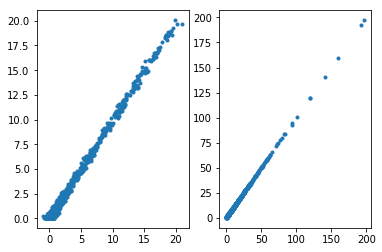

In [66]:
%matplotlib inline
import matplotlib.pyplot as plt

p_true = LogWrapper(dd.Gaussian(m=[2], S=[[1]]))

seed=42

m = Gauss(dim=1, noise_cov=0.1, seed=seed)
p = LogWrapper(dd.Uniform(lower=[-3], upper=[3], seed=seed))
s = ds.Identity()
g = dg.Default(model=m, prior=p, summary=s)
trn_data = g.gen(1000)
plt.subplot(1,2,1)
plt.plot(trn_data[1], trn_data[0], '.')

m = Gauss(dim=1, noise_cov=0.1, seed=seed)
p = p_true
s = ds.Identity()
g = dg.Default(model=m, prior=p, summary=s)
trn_data = g.gen(1000)
plt.subplot(1,2,2)
plt.plot(trn_data[1], trn_data[0], '.')

plt.show()

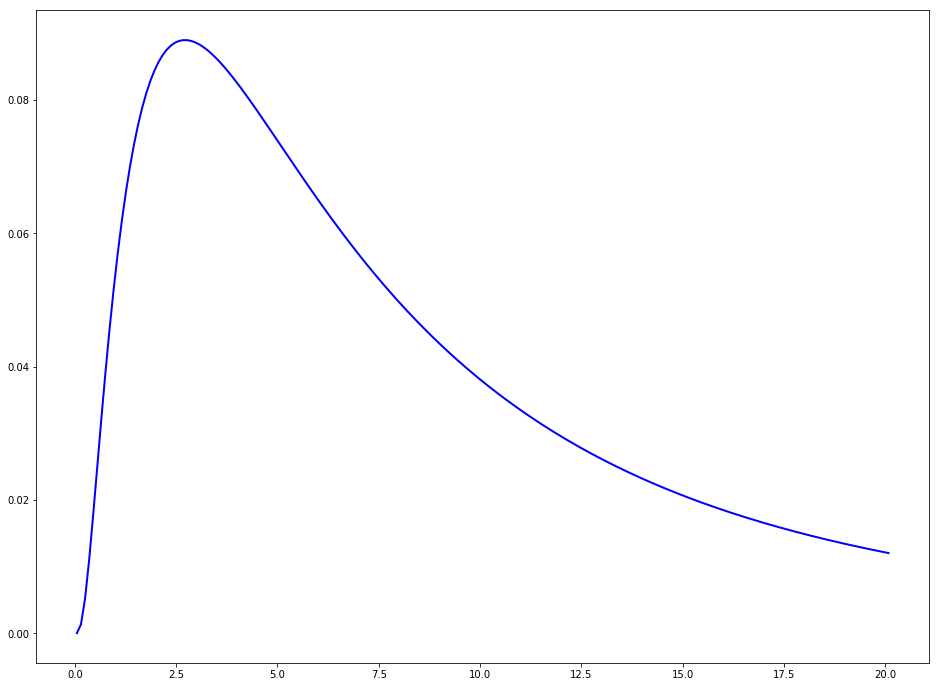

In [67]:

seeds = range(90, 110)
n_train = [1000]
rounds = len(n_train)

reinit_weights = True

all_outs_SNPE, all_outs_kSNPE, all_outs_CDELFI, all_outs_DDELFI = [], [], [], []
    
for seed in seeds[:1]:
    
    plt.figure(figsize=(16,12))

    xx = np.linspace(np.exp(-3), np.exp(3), 200).reshape(-1,1)
    
    plt.plot(xx,                p_true.eval(xx, log=False), 'b', linewidth=2)
    
        
    plt.show()


n_train : [1000]
epochs : [10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

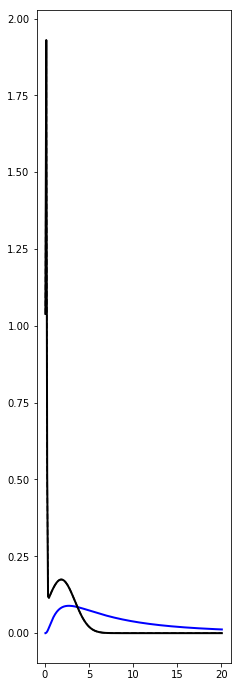

n_train : [1000]
epochs : [10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

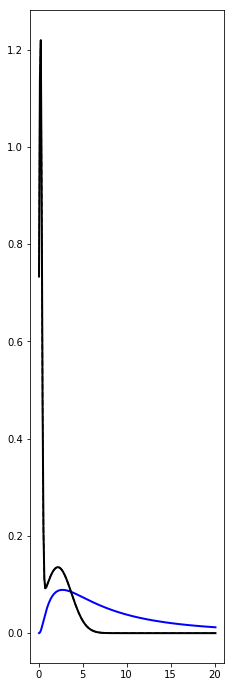

n_train : [1000]
epochs : [10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

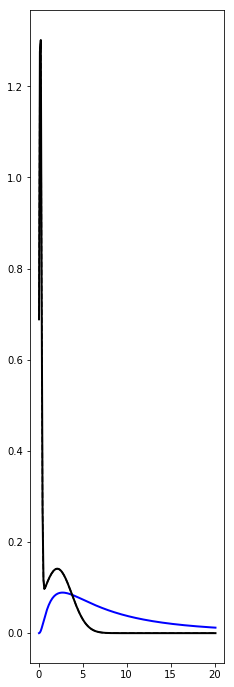

n_train : [1000]
epochs : [10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

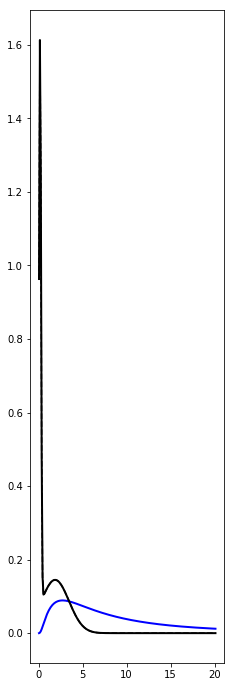

n_train : [1000]
epochs : [10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

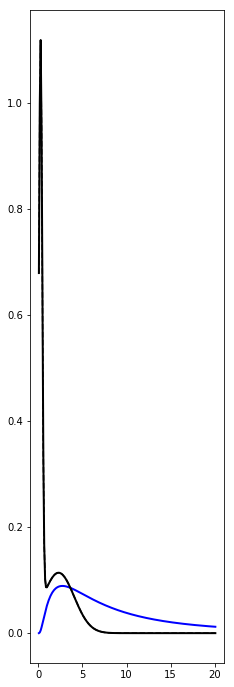

n_train : [1000]
epochs : [10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

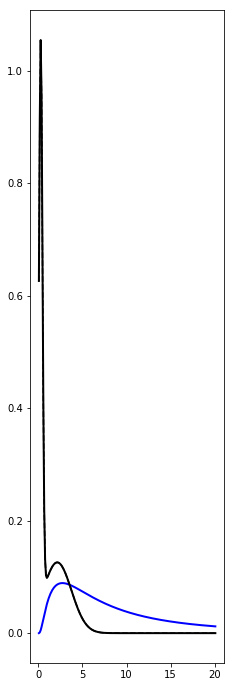

n_train : [1000]
epochs : [10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

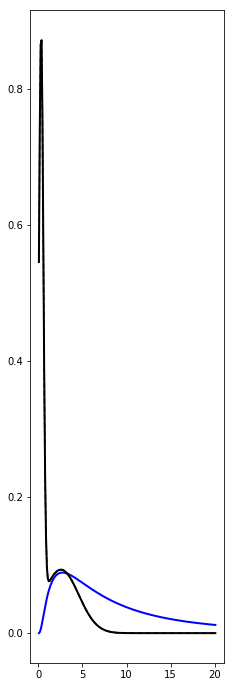

n_train : [1000]
epochs : [10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

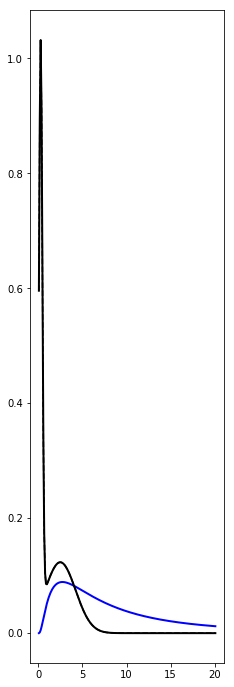

n_train : [1000]
epochs : [10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

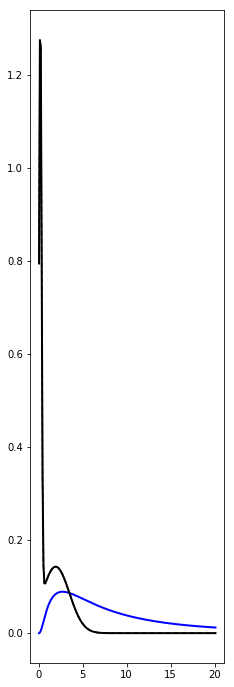

n_train : [1000]
epochs : [10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

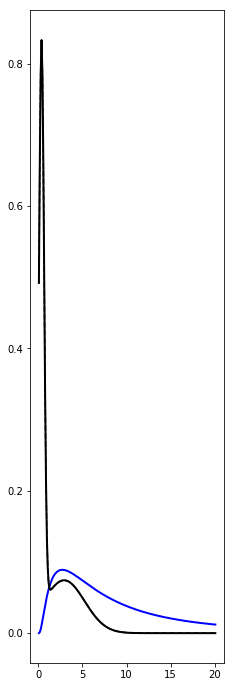

n_train : [1000]
epochs : [10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

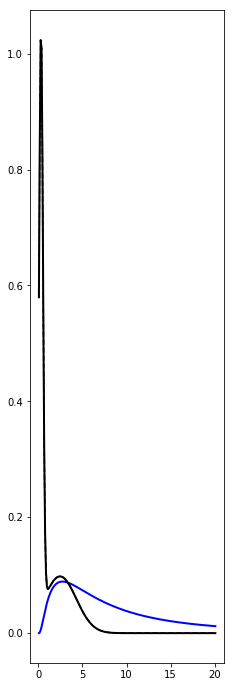

n_train : [1000]
epochs : [10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

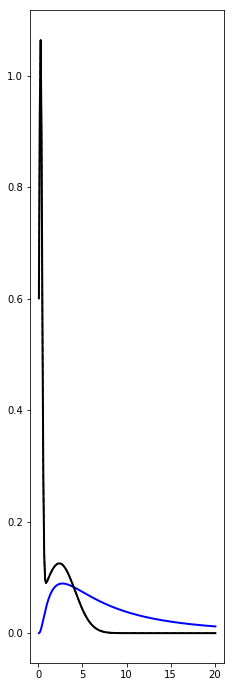

n_train : [1000]
epochs : [10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

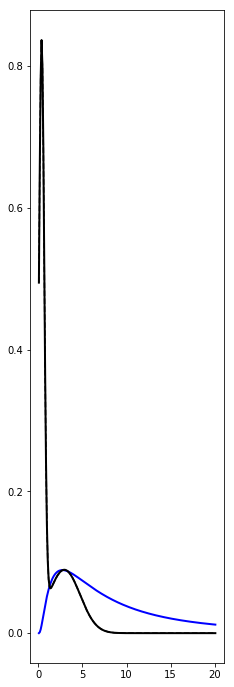

n_train : [1000]
epochs : [10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

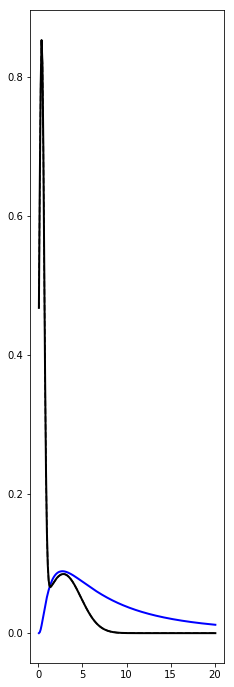

n_train : [1000]
epochs : [10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

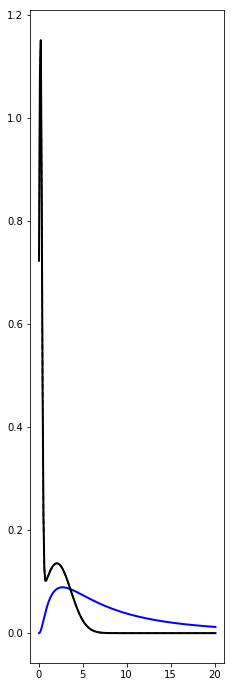

n_train : [1000]
epochs : [10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

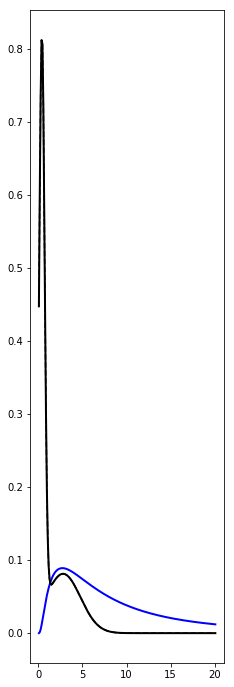

n_train : [1000]
epochs : [10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

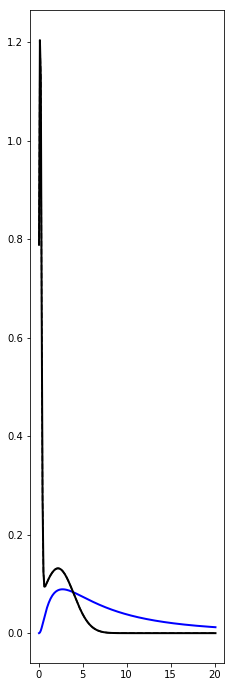

n_train : [1000]
epochs : [10000]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

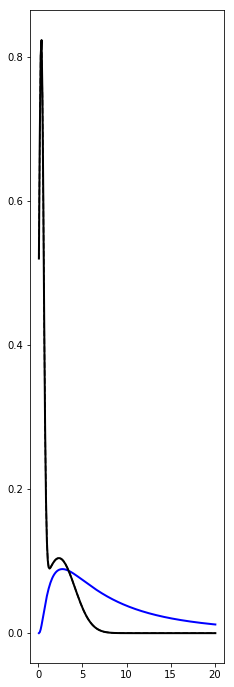

In [71]:

seeds = range(92, 110) #90
n_train = [1000]
rounds = len(n_train)

reinit_weights = True

all_outs_SNPE, all_outs_kSNPE, all_outs_CDELFI, all_outs_DDELFI = [], [], [], []
    
for seed in seeds:
    
    plt.figure(figsize=(16,12))

    xx = np.linspace(np.exp(-3), np.exp(3), 200).reshape(-1,1)
    
    #"""
    plt.subplot(1,4,1)
    
    out = run_panel_a(algo='CDELFI', rounds=rounds, seed=seed, n_train=n_train, 
                      reinit_weights=reinit_weights)
                      
    plt.plot(xx,                p_true.eval(xx, log=False), 'b', linewidth=2)
    try:
        plt.plot(xx,      out['posterior'].eval(xx, log=False), 'k', linewidth=2)
    except:
        tmp = out['posteriors'][-2] if out['posteriors'][-1] is None else out['posteriors'][-1]
        plt.plot(xx,      tmp.eval(xx, log=False), 'k')
    for r in range(rounds):
        try:
            plt.plot(xx, out['posteriors'][r].eval(xx, log=False), 'k--')
        except:
            pass
    
    all_outs_CDELFI.append(out)
    #"""

    #"""
    #plt.subplot(1,4,2)

    #out_SNPE = run_panel_a(algo='SNPE', rounds=rounds, seed=seed, n_train=n_train, 
    #                       reinit_weights=reinit_weights)
    
    #for r in range(rounds):
    #    w = out_SNPE['train_data'][r][2]
    #    w /= w.sum()
    #    print('ESS:' + str(1/np.sum(w**2)) + '/' + str(w.size))    

    #plt.plot(xx,                p_true.eval(xx, log=False), 'b', linewidth=2)
    #plt.plot(xx, out_SNPE['posterior'].eval(xx, log=False), 'r', linewidth=2)
    #for r in range(rounds):
    #    plt.plot(xx, out_SNPE['posteriors'][r].eval(xx, log=False), 'r--')
        
    #all_outs_SNPE.append(out_SNPE)        
    #"""
            
    #plt.subplot(1,4,3)
    
    #out_kSNPE = run_panel_a(algo='kSNPE', rounds=rounds, seed=seed, n_train=n_train,
    #                        reinit_weights=reinit_weights)
    #for r in range(rounds):
    #    w = out_kSNPE['train_data'][r][2]
    #    w /= w.sum()
    #    print('ESS:' + str(1/np.sum(w**2)) + '/' + str(w.size))
        
    #plt.plot(xx,                p_true.eval(xx, log=False), 'b', linewidth=2)
    #plt.plot(xx,out_kSNPE['posterior'].eval(xx, log=False), 'g', linewidth=2)
    #for r in range(rounds):
    #    plt.plot(xx,out_kSNPE['posteriors'][r].eval(xx, log=False), 'g--')
    #if rounds > 1:
    #    print('kernel cov: ', 1./out_kSNPE['log'][-1]['cbkrnl'].A )
    #all_outs_kSNPE.append(out_kSNPE)
    
    
    """
    plt.subplot(1,4,4)

    out_DDELFI = run_panel_a(algo='DDELFI', rounds=rounds, seed=seed, n_train=n_train, 
                           reinit_weights=reinit_weights)
    
    plt.plot(xx,                p_true.eval(xx, log=False), 'b', linewidth=2)
    plt.plot(xx, out_DDELFI['posterior'].eval(xx, log=False), 'r', linewidth=2)
    for r in range(rounds):
        plt.plot(xx, out_DDELFI['posteriors'][r].eval(xx, log=False), 'r--')
        
    all_outs_DDELFI.append(out_DDELFI)        
    """
            
        
    plt.show()


In [4]:

np.save('MoG_1D_unimodal_20seeds_5round_N1800_reinitW_impute_results', 
        {'seeds' : seeds, 
         'n_train' : n_train,
         'rounds' : rounds, 
         'reinit_weights' : reinit_weights,
         
         'p_true' : p_true,
         
         'res_CDELFI' : all_outs_CDELFI,
         'res_kSNPE' : all_outs_kSNPE,
         'res_SNPE' : all_outs_SNPE   ,
         'res_DDELFI' : all_outs_DDELFI,
    })

/Users/kaan/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


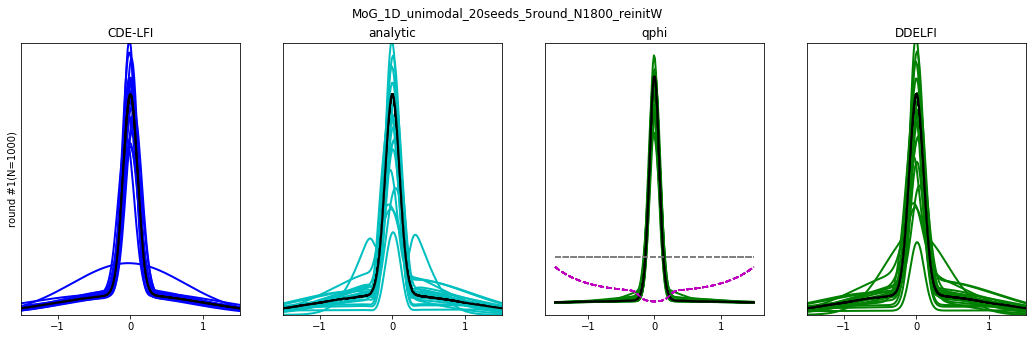

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(18,rounds*5))

fail_count_CDELFI = 0
for i in range(len(seeds)):
    
    seed = seeds[i]

    out = all_outs_CDELFI[i]
    #out_SNPE = all_outs_SNPE[i]
    #out_kSNPE = all_outs_kSNPE[i]
    out_DDELFI = all_outs_DDELFI[i]
    
    xx = np.linspace(-1.5, 1.5, 200).reshape(-1,1)

    broke_flag = False
    for r in range(rounds):
        if rounds > len(n_train) and r < rounds-1:
            r_ = 0
        elif rounds > len(n_train) and r == rounds-1:
            r_ = len(n_train)-1
        else: 
            r_ = r
        plt.subplot(rounds,4,1 + r*4)
        plt.plot(-20, -20, 'b--', linewidth=1.5)
        if r == rounds-1:
            try:
                plt.plot(xx,      out['posterior'].eval(xx, log=False), 'b', linewidth=2)
            except:
                tmp = out['posteriors'][-2] if out['posteriors'][-1] is None else out['posteriors'][-1]
                plt.plot(xx,      tmp.eval(xx, log=False), 'b--')
                broke_flag=True
                fail_count_CDELFI += 1
        else:
            plt.plot(xx, out['posteriors'][r].eval(xx, log=False), 'b')
        if r == 0:
            plt.title('CDE-LFI')
        plt.plot(xx,                p_true.eval(xx, log=False), 'k', linewidth=2)
        plt.ylabel('round #' + str(r+1) + '(N=' + str(n_train[r_]) + ')')
        plt.axis([-1.5, 1.5, 0, 2.7])
        plt.yticks([])
        plt.xticks([-1, 0, 1])
        plt.tick_params(top='off', left='off', right='off', labelleft='off', labelbottom='on')
        if broke_flag:
            plt.legend(['fail (' + str( fail_count_CDELFI ) + '/' +  str(len(seeds))  + ')'], loc=1, frameon=False)

        plt.subplot(rounds,4,2 + r*4)
        optim_data = out_DDELFI['optim_data'][r]
        
        prior_ylist = optim_data['prior'].eval(xx, log=False)
        prop_ylist = optim_data['proposal'].eval(xx, log=False)

        qphi_ylist = optim_data['qphi'].eval(xx, log=False)

        zz = np.linspace(-10, 10, 2000000).reshape(-1,1)
        Z = np.mean(optim_data['prior'].eval(zz, log=False) * optim_data['qphi'].eval(zz, log=False) \
                    / optim_data['proposal'].eval(zz, log=False)) * (zz[-1] - zz[0])

        plt.plot(xx, prior_ylist * qphi_ylist / (prop_ylist * Z), 'c', linewidth=2)
        plt.plot(xx,                p_true.eval(xx, log=False), 'k', linewidth=2)
        if r == 0:
            plt.title('analytic')
        plt.axis([-1.5, 1.5, 0, 2.7])
        plt.yticks([])
        plt.xticks([-1, 0, 1])
        plt.tick_params(top='off', left='off', right='off', labelleft='off', labelbottom='on')
        
        plt.subplot(rounds,4,3 + r*4)    
        plt.plot(xx, qphi_ylist, 'g', linewidth=2)
        if r == 0:
            plt.title('qphi')
            
        zz = zz[1:-1]
        Z_ = np.mean(optim_data['proposal'].eval(zz, log=False) * p_true.eval(zz, log=False) \
                    / optim_data['prior'].eval(zz, log=False)) * (zz[-1] - zz[0])
        
        plt.plot(xx, prop_ylist * p_true.eval(xx, log=False) / (prior_ylist * Z_), 'k', linewidth=2)
        
        plt.plot(xx, np.ones_like(xx), 'gray', ls='--')
        
        plt.plot(xx, prior_ylist / prop_ylist, 'm', ls='--')
        #plt.axis([-1.5, 1.5, 0, 6])
        plt.yticks([])
        plt.xticks([-1, 0, 1])
        plt.tick_params(top='off', left='off', right='off', labelleft='off', labelbottom='on')
        
        #print(optim_data['qphi'].eval([[0]], log=False) / (optim_data['proposal'].eval([[0]], log=False) * p_true.eval([[0]], log=False) \
        #            / (optim_data['prior'].eval([[0]], log=False) * Z_)))
        #print(optim_data['qphi'].eval([[0]], log=False) / optim_data['posterior'].eval([[0]], log=False))
        
        plt.subplot(rounds,4,4 + r*4)    
        plt.plot(xx,out_DDELFI['posteriors'][r].eval(xx, log=False), 'g', linewidth=2)
        if r == 0:
            plt.title('DDELFI')
        plt.plot(xx,                p_true.eval(xx, log=False), 'k', linewidth=2)
        plt.axis([-1.5, 1.5, 0, 2.7])
        plt.yticks([])
        plt.xticks([-1, 0, 1])
        plt.tick_params(top='off', left='off', right='off', labelleft='off', labelbottom='on')
    plt.suptitle('MoG_1D_unimodal_20seeds_5round_N1800_reinitW')
    plt.savefig('MoG_1D_unimodal_20seeds_5round_N1800_reinitW_impute.pdf')
    
plt.show()

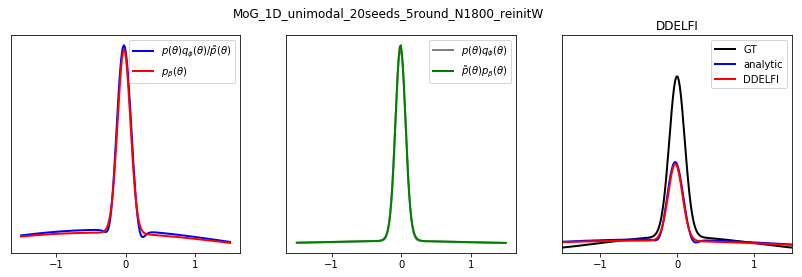

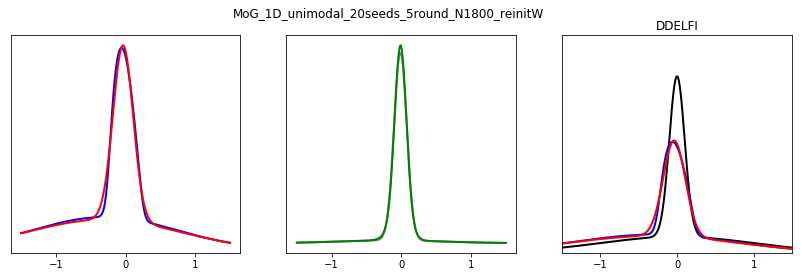

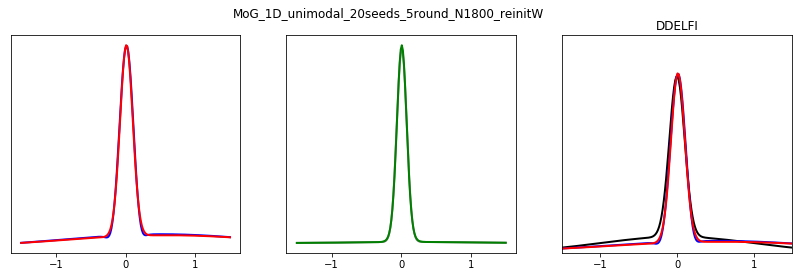

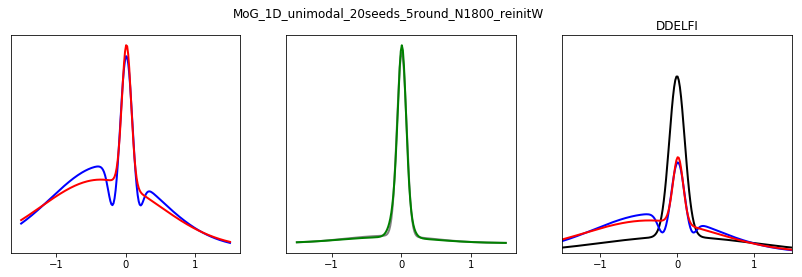

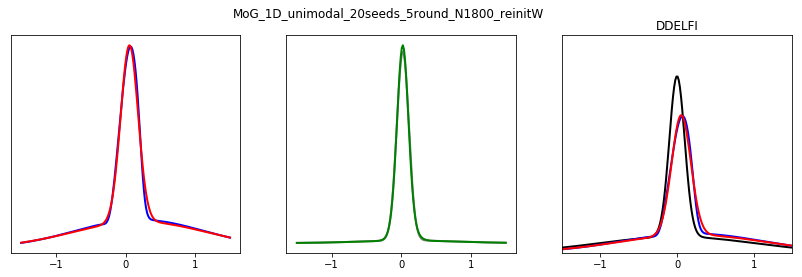

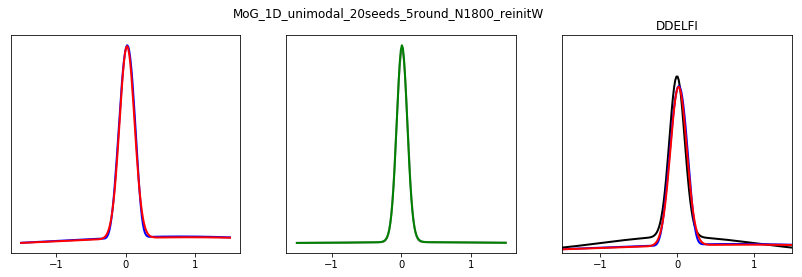

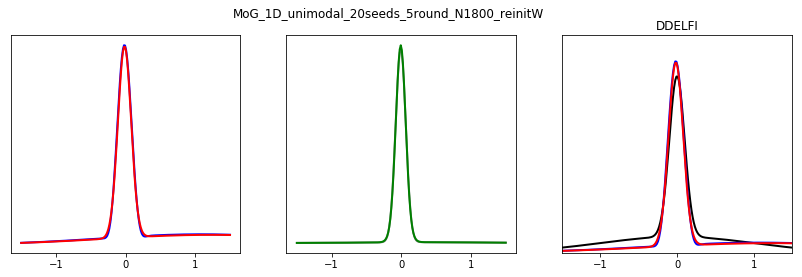

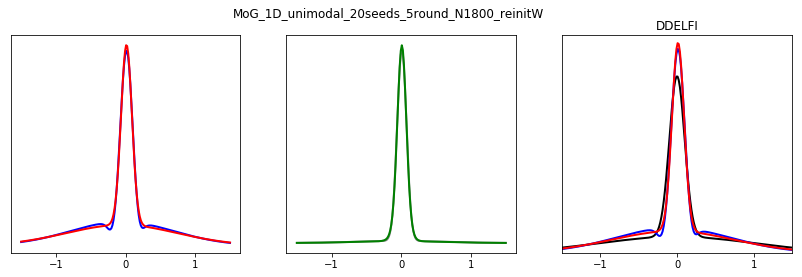

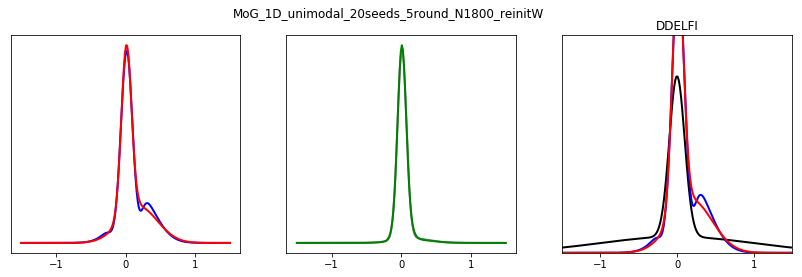

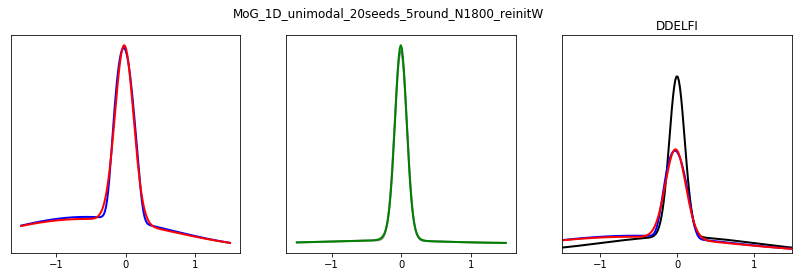

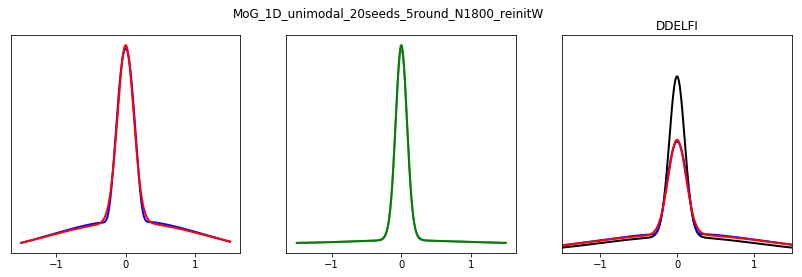

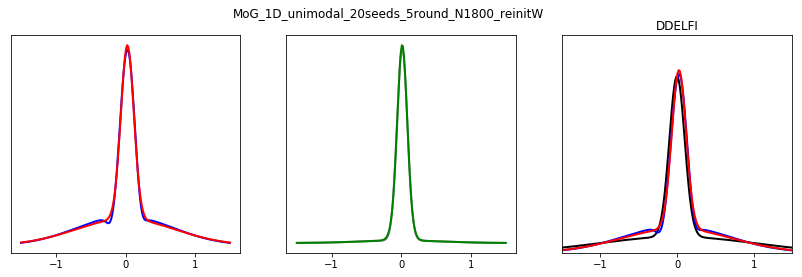

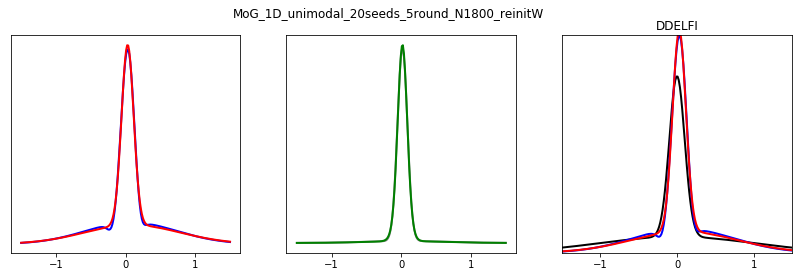

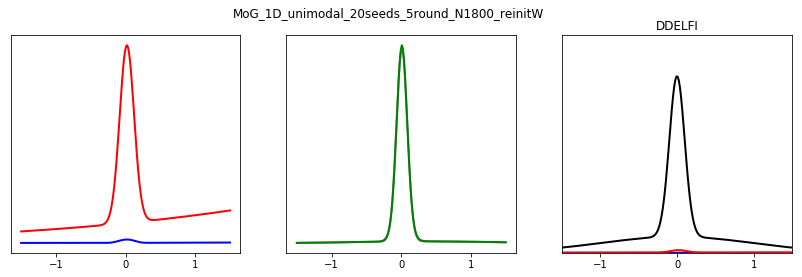

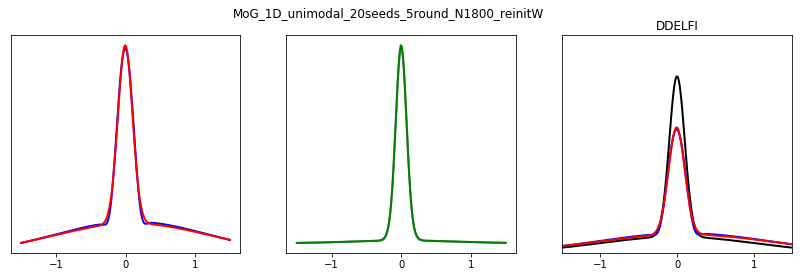

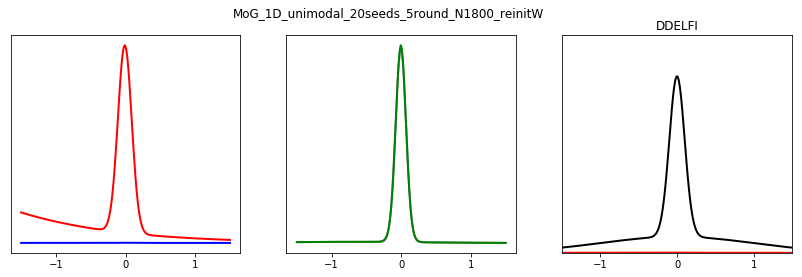

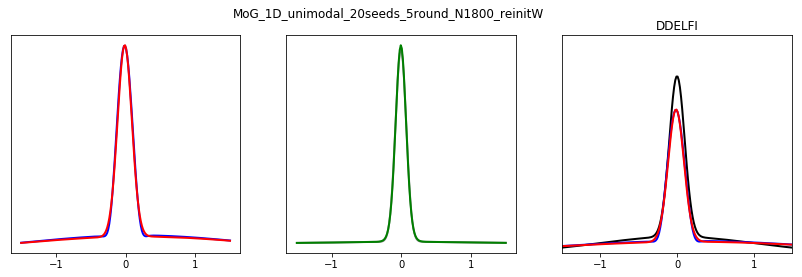

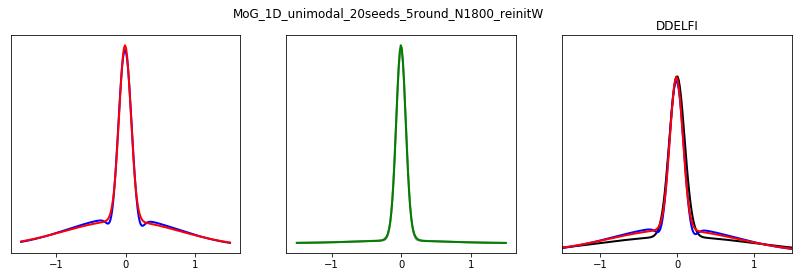

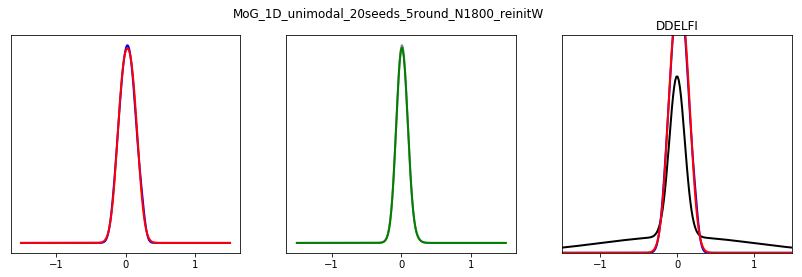

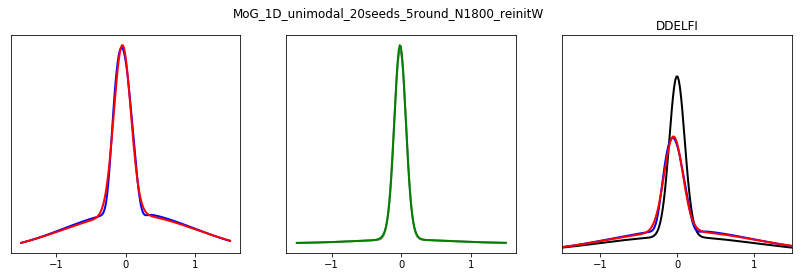

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt


# 11
# 10 bimodal in round 1
for i in range(len(seeds)):
    plt.figure(figsize=(14,rounds*4))
    seed = seeds[i]

    out_DDELFI = all_outs_DDELFI[i]
    
    xx = np.linspace(-1.5, 1.5, 200).reshape(-1,1)

    broke_flag = False
    for r in range(0, rounds):        
        plt.subplot(rounds,3, 3 + 3 * r)    
        #plt.plot(xx,out_DDELFI['posteriors'][r].eval(xx, log=False), 'r', linewidth=2, label='DDELFI')
        if r == 0:
            plt.title('DDELFI')
        plt.plot(xx, p_true.eval(xx, log=False), 'k', linewidth=2, label='GT')
        plt.axis([-1.5, 1.5, 0, 2.7])
        plt.yticks([])
        plt.xticks([-1, 0, 1])
        plt.tick_params(top='off', left='off', right='off', labelleft='off', labelbottom='on')
        
        if r >= 0:
            
            optim_data = out_DDELFI['optim_data'][r]

            prior_ylist = optim_data['prior'].eval(xx, log=False)
            prop_ylist = optim_data['proposal'].eval(xx, log=False)

            qphi_ylist = optim_data['qphi'].eval(xx, log=False)
            post_ylist = optim_data['posterior'].eval(xx, log=False)

            post_T_ylist = optim_data['posterior'].convert_to_T(dofs=1).eval(xx, log=False)

            Zbeta = np.mean(prior_ylist * qphi_ylist)
            Zprime = np.mean(prop_ylist * post_ylist)

            zz = np.linspace(-10, 10, 2000).reshape(-1,1)
            Z = np.mean(optim_data['prior'].eval(zz, log=False) * optim_data['qphi'].eval(zz, log=False) \
                        / optim_data['proposal'].eval(zz, log=False)) * (zz[-1] - zz[0])

            plt.plot(xx, prior_ylist * qphi_ylist / (prop_ylist * Z), 'b', linewidth=2, label='analytic')
            plt.plot(xx,out_DDELFI['posteriors'][r].eval(xx, log=False), 'r', linewidth=2, label='DDELFI')
            
            if i == 0 and r == 0:
                plt.legend()
            
            
            plot = plt.plot
        
            plt.subplot(rounds,3, 1 + 3 * r)
            plot(xx, prior_ylist * qphi_ylist / (prop_ylist * Z) , 'b', linewidth=2, label='$p(\\theta)q_\\phi(\\theta) / \\tilde p(\\theta)$')
            plot(xx, post_ylist, 'r', linewidth=2, label='$p_\\beta(\\theta)$')
            #plot(xx, post_T_ylist, 'r', ls='--', linewidth=2, label='$p_\\beta(\\theta).T(df=3)$')
            #plt.yticks([0])
            plt.xticks([-1, 0, 1])
            plt.tick_params(top='off', left='off', right='off', labelleft='off', labelbottom='on')

            if i == 0 and r == 0:
                plt.legend()

            plt.subplot(rounds,3, 2 + 3 * r)
            plot(xx, prior_ylist * qphi_ylist / Zbeta, 'gray', linewidth=2, label='$p(\\theta)q_\\phi(\\theta)$')
            plot(xx, prop_ylist * post_ylist / Zprime, 'g', linewidth=2, label='$\\tilde p(\\theta) p_\\beta(\\theta)$')
            #plt.yticks([0])
            plt.xticks([-1, 0, 1])
            plt.tick_params(top='off', left='off', right='off', labelleft='off', labelbottom='on')

            if i == 0 and r == 0:
                plt.legend()
            
    plt.suptitle('MoG_1D_unimodal_20seeds_5round_N1800_reinitW')
    plt.savefig('MoG_1D_unimodal_20seeds_5round_N1800_reinitW_s{}.pdf'.format(i))
    
    plt.show()

In [ ]:
import theano
import lasagne.layers as ll

r = -1

net = out_SNPE['network']
obs = out_SNPE['obs']
stats_mean = out_SNPE['stats_mean']
stats_std  = out_SNPE['stats_std']
trn_data = out_SNPE['train_data'][r]

print(net.layer.keys())

cbk_feature_layer = 4
ks = list(net.layer.keys())
hl = net.layer[ks[cbk_feature_layer]]

stat_features = theano.function(
    inputs=[net.stats],
    outputs=ll.get_output(hl))

fstats = stat_features(trn_data[1]).reshape(trn_data[1].shape[0],-1)
obs_z = (obs - stats_mean) / stats_std
fobs_z = stat_features(obs_z).reshape(1,-1)

plt.figure(figsize=(12, 20))
for i in range(fstats.shape[1]):
    plt.subplot(fstats.shape[1]//4+1, 4, i+1)
    plt.hist(fstats[:,i], normed=True)
    plt.plot(fobs_z[0,i], 0.5, 'r*', markerSize=8)
plt.show()

In [ ]:
j = 0
for r in range(rounds):
    w = all_outs_SNPE[j]['train_data'][r][2]
    w /= w.sum()
    print('ESS raw', 1./np.sum(w**2))

    w = all_outs_kSNPE[j]['train_data'][r][2]
    w /= w.sum()
    print('ESS raw', 1./np.sum(w**2))


In [ ]:
obs = np.array([[0]])

def un_zscore(trn_data_r, seed):
    
    m = GaussMixture(dim=1, noise_cov=[1.0, 0.01], seed=seed)
    p = dd.Uniform(lower=[-10], upper=[10], seed=seed)
    s = ds.Identity()
    g = dg.Default(model=m, prior=p, summary=s)
    
    _,_ = g.gen(1, skip_feedback=True, verbose=False) # DELFI uses this to figure the shape of th, x

    _, stats = g.gen(100, verbose=False)
    stats_mean = np.nanmean(stats, axis=0)
    stats_std = np.nanstd(stats, axis=0)    
    
    return (trn_data_r[1] * stats_std) + stats_mean        
        
def reg_adj(th, x, xo, mu, sig):
                
    return mu(xo) + sig(xo) * (th - mu(x))/sig(x)

thp = p_true.gen(100000)
p_uni = dd.Gaussian(m=-0.11701747*np.ones(1), S=0.65295111*np.eye(1))
plt.figure(figsize=(16,16))

ll_unim = np.zeros(len(seeds))
ll_true = np.zeros(len(seeds))
ll_test = np.zeros(len(seeds))
for i in range(len(seeds)):    
    r = 0
    trn_data = all_outs_SNPE[i]['train_data'][r]

    x = un_zscore(trn_data, seeds[i])

    def mu(x):
        return x
    def sig(x):
        return 1.

    th_ = reg_adj(trn_data[0], x, obs, mu, sig)

    plt.subplot(5,5,i+1)
    plt.hist(th_, bins=np.linspace(-3, 3, 20), normed=True)
    plt.plot(np.linspace(-3, 3, 200), 
             p_true.eval(np.linspace(-3, 3, 200).reshape(200,1),log=False),
             linewidth=2, color='k')
    plt.plot(np.linspace(-3, 3, 200), 
             all_outs_SNPE[i]['posteriors'][r].eval(np.linspace(-3, 3, 200).reshape(200,1),log=False),
             linewidth=2, color='r')
    plt.title('seed ' + str(seeds[i]) + ', round ' + str(r+1))
    
    ll_unim[i] = np.sum(p_uni.eval(th_))
    ll_true[i] = np.sum(p_true.eval(th_))
    ll_test[i] = np.sum(all_outs_SNPE[i]['posteriors'][r].eval(thp))
    
#plt.plot(ll_unim, 'ro-')

plt.subplot(5,1,5)
plt.plot(seeds, ll_true, 'bo-')
plt.ylabel('log-prob under true posterior')
plt.xlabel('#seed')
#plt.savefig('MoG_1D_bimodal_20seeds_3round_N1800_20seeds_regAdj_round1.pdf')
plt.show()


plt.plot(ll_test, ll_true, 'bo')
plt.ylabel('log-prob of data under true posterior')
plt.xlabel('log-prob of poster draws under fitted model')
plt.show()

print( np.corrcoef(ll_test, ll_true) )

In [ ]:
import theano
import theano.tensor as tt

idx_bad = np.array([0,1,2,5,10,11,13,14,16,17,18])
idx_good = np.setdiff1d(np.arange(20), idx_bad)
losses = np.array( [ all_logs[i][-1]['loss'][-1] for i in range(20)] )
lls = np.zeros_like(losses)


for i in range(n_rerun):
    ll = -tt.mean(all_infs[i].network.lprobs)
    f_eval_ll = theano.function(
            inputs=[all_infs[i].network.params, all_infs[i].network.stats],
            outputs=ll)
    lls[i] = f_eval_ll(all_train_datas[i][0][0], all_train_datas[i][0][1])

plt.figure(figsize=(16,9))
plt.subplot(2,4,1)
for i in range(20):
    if i in idx_bad:
        plt.plot(xx, all_posteriors[i][-1].eval(xx, log=False), 'r')
    else:
        plt.plot(xx, all_posteriors[i][-1].eval(xx, log=False), 'b')
plt.plot(xx, p_true.eval(xx, log=False), 'k')
plt.xlabel('theta')
plt.title('posterior estimates')

plt.subplot(2,4,2)
for i in range(len(seeds)):
    xx_ = np.arange(all_logs[i][-1]['loss'].size)[::100]
    if i in idx_bad:
        plt.plot(xx_,all_logs[i][-1]['loss'][::100], 'r')
    else:
        plt.plot(xx_,all_logs[i][-1]['loss'][::100], 'b')
plt.axis([0, all_logs[i][-1]['loss'].size, 0, 5])
plt.title('SVI loss')
plt.xlabel('iteration')

plt.subplot(2,4,3)
plt.plot(idx_bad,  losses[idx_bad], 'ro')
plt.plot(idx_good, losses[idx_good], 'bo')
plt.legend(['fail', 'succes'], loc=1)
plt.axis([-1,21,0, 5])
plt.title('final SVI loss')
plt.xlabel('#seed')

plt.subplot(2,4,4)
plt.plot(idx_bad,  lls[idx_bad], 'ro')
plt.plot(idx_good, lls[idx_good], 'bo')
plt.title('neg. log-likelihood (aka log-loss)')
plt.xlabel('#seed')
plt.axis([-1,21,0, 5])

#plt.subplot(2,5,4)
#plt.plot(idx_bad,  losses[idx_bad] -lls[idx_bad], 'ro')
#plt.plot(idx_good, losses[idx_good]-lls[idx_good], 'bo')
#plt.title('regularizer to prior (aka D_KL-term)')
#plt.axis([-1,21,0, 2.3])
#plt.xlabel('#seed')

xs_ = [np.array([[-2]]), 
       np.array([[-1]]), 
       np.array([[ 0]]), 
       np.array([[ 1]]), 
       np.array([[ 2]])]

xx = np.linspace(-4,4,300).reshape(-1,1)
for j in range(len(xs_)):
    
    x_ = xs_[j]
    plt.subplot(2,len(xs_),len(xs_)+j+1)
    
    for i in range(20):

        pest=all_infs[i].predict(x_)
        if i in idx_bad:
            plt.plot(xx, pest.eval(xx, log=False), 'r')
        else:
            plt.plot(xx, pest.eval(xx, log=False), 'b')
        plt.title('x = ' + str(x_[0,0]))
        plt.xlabel('theta')
        
    if j==0:
        plt.ylabel('conditional densities')

#plt.suptitle('signs for multiple optima in MDN final losses fit to 1D unimodal MoG')
#plt.savefig('MoG_1D_bimodal_20seeds_3round_N1800_reinitW_seed93_20repeats_round1_loss_decomposition.pdf')
plt.show()
